In [1]:
import numpy as np
import matplotlib.pyplot as plt

exp_dir = 'figs/test/name(bloodvesselsDeepTFM6sls)@rotation_lambda(10000.0)@lambda_scale_factor(1)@T(32)@lr_H(1.0)@img_size(256)@num_samples_train(8)@num_samples_valtest(8)@batch_size_train(4)@batch_size_valtest(4)@H_init(uniformones_FourierBased)/save_special'

In [10]:
import torch
from torch.nn import functional as F

def fft_conv2d(X, filter_, **args): # X.shape: (b, 1, m, m), filter_.shape: (1, 1, f, f) -> similar to standard conv [note: f> m]
    #print('fft conv used !!!')
    X= X[:, 0]
    filter_= filter_[:, 0]
    
    _, m, _ = X.shape
    _, f, _ = filter_.shape
    a, b, c, d= (f-m)//2 + 1, (f-m)//2, (f-m)//2 + 1, (f-m)//2
    
    X= torch.nn.functional.pad(X, (a, b, c, d)) # make X.shape= filter_.shape [note: filter_ is larger than image]
    X = torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(X)))
    filter_ = torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(filter_)))
    X = X * filter_
    X = torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(X)))
    
    X= X[:, c:-d, a:-b] ## c+1: -d+1 instead c: -d -> because, freq-domain mult. shift the image (DO NOT KNOW WHY??)
    return X.abs().unsqueeze(dim= 1) # shape: (b, 1, m, m)



def special_Conv2d(X, filter_, padding, conv_func= None): #X.shape: (b, T, m, m), filter.shape: (1, 1, f, f) 
    if conv_func ==None: conv_func= F.conv2d
    
    b, T, m, _ = X.shape
    out = conv_func(X.reshape(b*T, 1, m, m), filter_, padding= padding)
    return out.reshape(b, T, m, m)

def forward_model_allH(X, Ht, conv_func, sPSF, exPSF, emPSF): #X: (m, 1, Nx, Ny), Ht: (1, T, Nx, Ny), sPSF: (N1, N1), exPSF: (N2, N2)
    padding_spsf = (sPSF.shape[0]-1)//2
    padding_expsf = (exPSF.shape[0]-1)//2
    padding_empsf = (emPSF.shape[0]-1)//2

    sPSF= sPSF.view(1, 1, sPSF.shape[0], sPSF.shape[1]) 
    exPSF= exPSF.view(1, 1, exPSF.shape[0], exPSF.shape[1])
    emPSF= emPSF.view(1, 1, emPSF.shape[0], emPSF.shape[1])

    A1= special_Conv2d(Ht, exPSF, padding= padding_expsf, conv_func= conv_func)*X
    A2= special_Conv2d(A1, sPSF, padding= padding_spsf, conv_func= conv_func)
    yt= special_Conv2d(A2, emPSF, padding= padding_empsf, conv_func= conv_func)
    #print('faster code !!!')
    return yt


In [11]:
from modules.psfs import *

device= 'cuda:0'

yt_val = np.load(f'{exp_dir}/1_yt_val.npy')
X_val = np.load(f'{exp_dir}/1_X_val.npy')
Ht_val = np.load(f'{exp_dir}/1_Ht_val.npy')

X_val, Ht_val= torch.from_numpy(X_val).to(device), torch.from_numpy(Ht_val).to(device)

In [12]:
sPSF= load_psf_from_npy("psfs/psfs_bloodvesselsDeepTFM6sls_spsf.npy").to(device)
exPSF= load_psf_from_npy("psfs/psfs_bloodvesselsDeepTFM6sls_expsf.npy").to(device)
emPSF= load_psf_from_npy("psfs/psfs_bloodvesselsDeepTFM6sls_empsf.npy").to(device)


In [18]:
lambda_up= forward_model_allH(X_val[0:4], Ht_val[0:4], fft_conv2d, sPSF, exPSF, emPSF)

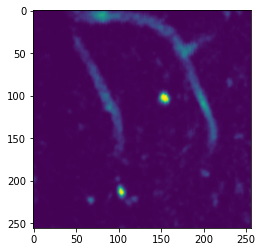

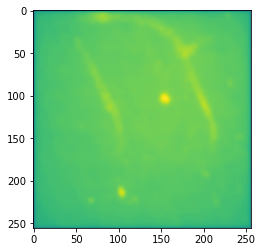

In [21]:
plt.imshow(X_val[0,0].cpu())
plt.show()
plt.imshow(lambda_up[0,0].cpu())